# Evaluation of Probabilistic Retrieval System Implemented

In [3]:
import ProbIR as PIR
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np

- Presentation of the dataset
- Use other metrics

In [4]:
doc_set = []
doc_id = ""
doc_text = ""
with open('./cisi/CISI.ALL') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
doc_count = 0
for l in lines:
    if l.startswith(".I"):
        doc_id = int(l.split(" ")[1].strip())-1
    elif l.startswith(".X"):
        doc_set.append(doc_text.lstrip(" "))
        doc_id = ""
        doc_text = ""
    else:
        doc_text += l.strip()[3:] + " " # The first 3 characters of a line can be ignored.    

with open('./cisi/CISI.QRY') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
    
qry_set = {}
qry_id = ""
for l in lines:
    if l.startswith(".I"):
        qry_id = int(l.split(" ")[1].strip()) -1
    elif l.startswith(".W"):
        qry_set[qry_id] = l.strip()[3:]
        qry_id = ""

rel_set = {}
with open('./cisi/CISI.REL') as f:
    for l in f.readlines():
        qry_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0]) -1
        doc_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1])-1
        if qry_id in rel_set:
            rel_set[qry_id].append(doc_id)
        else:
            rel_set[qry_id] = []
            rel_set[qry_id].append(doc_id)

In [5]:
print("Number of documents: ", len(doc_set))
print("Number of test queries: ", len(qry_set))

Number of documents:  1460
Number of test queries:  112


In [5]:
for i in range(len(doc_set)):
    doc_set[i] = PIR.Document(str(i),doc_set[i])

IRS = PIR.ProbIR.from_corpus(doc_set, stemmer=False)

Computing tf scores: 100%|██████████| 12504/12504 [00:00<00:00, 14725.83it/s]


## Parameters tuning

In [23]:
b_grid = np.linspace(0,1,10)
k1_grid = np.linspace(1,2,10)
res = np.zeros((10,10))

B = 22
results = 15

for i in range(len(b_grid)):
    for j in range(len(k1_grid)):
        map = np.zeros(B)
        for k in range(B): 
            ret = IRS.query(qry_set[k], results=results, b=b_grid[i],k=k1_grid[j], pseudorel=0, test_mode=True)
            idx = set([doc.to_int() for doc in ret])
            rel_set_toset = set(rel_set)
            map[k] = len(idx.intersection(rel_set_toset))/results
        res[i][j] = np.sum(map)/B
    print("Iter ", i+1, "/10")

Iter  1 /10
Iter  2 /10
Iter  3 /10
Iter  4 /10
Iter  5 /10
Iter  6 /10
Iter  7 /10
Iter  8 /10
Iter  9 /10
Iter  10 /10


In [31]:
res

array([[0.08787879, 0.08484848, 0.08787879, 0.08787879, 0.08787879,
        0.08787879, 0.09090909, 0.09090909, 0.0969697 , 0.0969697 ],
       [0.07575758, 0.07878788, 0.07878788, 0.07878788, 0.08181818,
        0.08181818, 0.08181818, 0.08484848, 0.08787879, 0.08787879],
       [0.07575758, 0.07878788, 0.08181818, 0.07878788, 0.07575758,
        0.07575758, 0.07575758, 0.07878788, 0.08181818, 0.08181818],
       [0.06666667, 0.06666667, 0.06363636, 0.06363636, 0.06666667,
        0.06666667, 0.06969697, 0.06969697, 0.06969697, 0.06969697],
       [0.06666667, 0.06969697, 0.06969697, 0.06969697, 0.06969697,
        0.06363636, 0.06060606, 0.06060606, 0.06060606, 0.06060606],
       [0.05757576, 0.05757576, 0.06363636, 0.06060606, 0.05757576,
        0.05757576, 0.05757576, 0.05757576, 0.05757576, 0.05757576],
       [0.06060606, 0.06060606, 0.06060606, 0.05757576, 0.05757576,
        0.05757576, 0.05757576, 0.05454545, 0.05151515, 0.05757576],
       [0.05454545, 0.05454545, 0.0545454

## Test of the system with best parameters

In [36]:
B = 112-22
map = np.zeros(B)
results = 15
b = 0
k1 = 1.9
for j in tqdm(range(22,B)): 
        ret = IRS.query(qry_set[j], results=results, b=b,k=k1, pseudorel=0, test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        rel_set_toset = set(rel_set)
        map[j-22] = len(idx.intersection(rel_set_toset))/results


print("MAP: ", np.sum(map)/(B))

100%|██████████| 70/70 [00:50<00:00,  1.39it/s]

MAP:  0.03985507246376812


## Does pseudo-relevance feedback positively affect MAP?

In [44]:
B = 22
pseudo_grid = [1,2,3,4,5,10,20,50]
map = np.zeros(len(pseudo_grid))
results = 25
b = 0
k1 = 1.9

for i in tqdm(range(len(pseudo_grid))):
    ap = np.zeros(B)
    for j in (range(B)): 
        ret = IRS.query(qry_set[j], results=results, b=b,k=k1, pseudorel=pseudo_grid[i], test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        rel_set_toset = set(rel_set)
        ap[j] = len(idx.intersection(rel_set_toset))/results
    map[i] = np.sum(ap)/B


100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


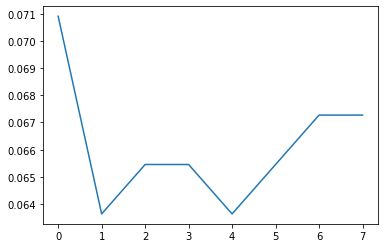

In [45]:
plt.plot(map)

## Stemming improves results?

In [46]:
IRS = PIR.ProbIR.from_corpus(doc_set, stemmer=True)

Computing tf scores: 100%|██████████| 12504/12504 [00:00<00:00, 13316.21it/s]


In [47]:
B = 112-22
map = np.zeros(B)
results = 15
b = 0
k1 = 1.9
for j in tqdm(range(22,B)): 
        ret = IRS.query(qry_set[j], results=results, stemmer=True, b=b,k=k1, pseudorel=0, test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        rel_set_toset = set(rel_set)
        map[j-22] = len(idx.intersection(rel_set_toset))/results


print("MAP: ", np.sum(map)/(B))

100%|██████████| 68/68 [00:48<00:00,  1.40it/s]

MAP:  0.05333333333333333
